In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
import matplotlib.pyplot as plt
from fitting import create_ensemble, get_data, get_datasets

import sys
sys.path.append("../")

folder = ""
save_dir = "alpha_1000_snapshot"
all_k, all_images, bins, xx = get_data(folder)
train_dset, test_dset = get_datasets(all_k, all_images, save_dir)

bandwidth = torch.tensor(0.0)
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)
ensemble = ensemble
ensemble.cuda();

/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([20, 3, 180, 180])
torch.Size([20, 3])
torch.Size([180])


In [2]:
all_k.shape

torch.Size([20, 3])

In [3]:
train_k = train_dset.k
train_k = train_k.cuda()

train_im = train_dset.images
train_im = train_im.cpu()

test_k = test_dset.k
test_k = test_k.cuda()

test_im = test_dset.images
test_im = test_im.cpu()

In [4]:
recompute_images = True
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = dist.sample([100000]).cuda()

        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1].cuda())[0].unsqueeze(0) for i in range(len(ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()

        torch.save(model_pred, "model_pred_images.pt")
        #torch.save(test_pred, "test_pred_images.pt")
    else:
        train_pred = torch.load("train_pred_images.pt")
        test_pred = torch.load("test_pred_images.pt")

In [5]:
# compare initial beam distributions
from torch_track import Beam
defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

# generate beams from model
pred_initial_beams = [ele.beam_generator() for ele in ensemble]


tensor(0.0031, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<StdBackward0>)


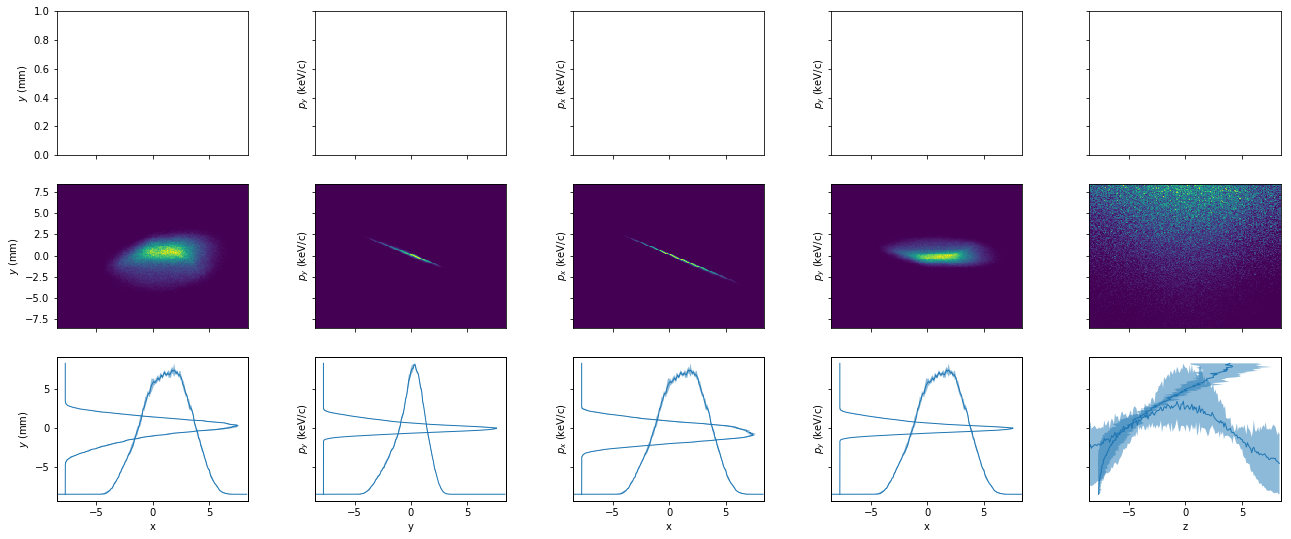

In [6]:
from visualization import add_image, add_projection, add_image_projection
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase
pairs = [["x","y"],["y","py"],["x","px"],["x","py"],["z","pz"]]

fig,ax = plt.subplots(3,len(pairs), sharex="col",sharey="row")
fig.subplots_adjust(wspace=0.35, right=0.975, top=0.975)
fig.set_size_inches(20,8)
    
plot_bins = bins/2
#plot_bins = plot_bins * 1e3

vmax = None
linewidth=1.0
for g, pair in enumerate(pairs):
    i = g
    
    pb = [plot_bins]*2
    scale = 1e3
    #if pair == ["z","pz"]:
    #    plot_bins = bins*10
    #    scale = 1e6
    
    #print(np.max(gt_image))
    _, pred_image = add_image(ax[1][i], *pair, pred_initial_beams, pb,
                           scale_axis=scale,vmax=vmax)

    if pair[-1]=="y":
        for a in ax[:,i]:
            a.set_ylabel("$y$ (mm)")
    elif pair[-1]=="py":
        for a in ax[:,i]:
            a.set_ylabel("$p_y$ (keV/c)")
    elif pair[-1]=="px":
        for a in ax[:,i]:
            a.set_ylabel("$p_x$ (keV/c)")

    # x projections
    #max_dens = 250
    axa = ax[2][i].twinx()
    add_projection(axa, pair[0], pred_initial_beams, pb[0], x_scale=scale, y_scale=1)
    #axa.set_ylim(0,max_dens)
    axa.set_yticks([])
    
    # y projections
    axb = ax[2][i].twiny()
    add_projection(axb, pair[1], pred_initial_beams, pb[1],axis="y", x_scale=scale, y_scale=1)
    #axb.set_xlim(0,max_dens)
    axb.set_xticks([])
    
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)
    ax[-1][i].set_xlabel(pair[0])

# set rasterization for pcolor
for k in range(ax.shape[-1]):
    try:
        ax[0,k].collections[0].set_rasterized(True)
        ax[1,k].collections[0].set_rasterized(True)
    except IndexError:
        pass





print(pred_initial_beams[0].z.std())
print(pred_initial_beams[0].pz.std())

# set ticks for lower x-axis
#for a in ax[-1]:
#    a.set_xticks([-20,0,20])
    
#fig.tight_layout()


In [7]:
# compare projections
from visualization import compare_image_projections

fig = compare_image_projections(xx[0].T[0], test_im, test_pred)
fig.set_size_inches(16,16)

NameError: name 'test_pred' is not defined

In [ ]:
# compare projections
from visualization import compare_image_projections

fig = compare_image_projections(xx[0].T[0], train_im, train_pred)
fig.set_size_inches(16,16)

In [ ]:
# plot reconstructed beam dist
from visualization import add_projection
beams = [ele.beam_generator() for ele in ensemble]

fig,ax = plt.subplots()
#add_projection(ax, "x", beams, xx[0].T[0])
#add_projection(ax, "y", beams, xx[0].T[0])
#add_projection(ax, "px", beams, xx[0].T[0])
#add_projection(ax, "py", beams, xx[0].T[0])
add_projection(ax, "z", beams, xx[0].T[0])
add_projection(ax, "pz", beams, xx[0].T[0]*2)

In [ ]:
# plot results from initial_ensemble
# get initial set of estimators
initial_estimators = []
for _ in range(200):
    initial_estimators.append(ensemble._make_estimator())

initial_estimators = torch.nn.ModuleList(initial_estimators)
initial_estimators.load_state_dict(torch.load("initial_ensemble.pt"))

In [ ]:
# plot reconstructed beam dist
from visualization import add_projection
initial_beams = [ele.beam_generator() for ele in initial_estimators]

fig,ax = plt.subplots(3,1,sharex="all")
fig.set_size_inches(5,10)
add_projection(ax[0], "z", beams, xx[0].T[0], "_fit")
add_projection(ax[0], "z", initial_beams, xx[0].T[0], "_initial")

add_projection(ax[1], "pz", beams, xx[0].T[0], "_fit")
add_projection(ax[1], "pz", initial_beams, xx[0].T[0], "_initial")

add_projection(ax[2], "x", beams, xx[0].T[0], "_fit")
add_projection(ax[2], "x", initial_beams, xx[0].T[0], "_initial")

for ele in ax:
    ele.legend()
fig.savefig("entropy.png")